In [5]:
import pandas as pd
import evaluate
from datasets import load_dataset, Audio
from transformers import pipeline, AutoProcessor, AutoModelForPreTraining, Wav2Vec2Processor, Wav2Vec2ForCTC, HubertForCTC, AutoModelForSpeechSeq2Seq
import torch
from itertools import islice
import nemo.collections.asr as nemo_asr
import matplotlib.pyplot as plt

In [6]:
# 1. Define models and datasets
models = [
    "facebook/wav2vec2-base-960h",
    "facebook/hubert-large-ls960-ft",
    "openai/whisper-large-v3",
    "ibm-granite/granite-speech-3.3-8b",
    "nvidia/parakeet-tdt-0.6b-v2",
]
datasets_info = [
    ("mozilla-foundation/common_voice_16_1", {"split": "test", "field": "sentence"}),
    ("openslr/librispeech_asr",      {"split": "test.clean", "field": "text"}),
    # ("espnet/yodas2",                {"field": "text"}),
    ("edinburghcstr/ami",            {"split": "test", "config": "ihm", "field": "text"}),
    ("edinburghcstr/ami",            {"split": "test", "config": "sdm", "field": "text"}),
    ("distil-whisper/earnings22",    {"split": "test",       "field": "transcription"}),
    ("facebook/voxpopuli",       {"split": "test",       "field": "raw_text"}),
    ("google/fleurs",            {"split": "test",       "field": "transcription"}),
]

In [7]:
# 2. Load metrics
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [ ]:
# 3. Loop over models & datasets
results = []
device = 0 if torch.cuda.is_available() else -1

for model_name in models:
    print(f"\nLoading pipeline for {model_name}…")
    if "whisper" in model_name:
        model_id = "openai/whisper-large-v3"

        model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id, torch_dtype=torch.float16, low_cpu_mem_usage=True, use_safetensors=True
        )
        model.to(device)

        processor = AutoProcessor.from_pretrained(model_id)

        asr = pipeline(
            "automatic-speech-recognition",
            model=model,
            tokenizer=processor.tokenizer,
            feature_extractor=processor.feature_extractor,
            torch_dtype=torch.float16,
            device=device,
        )
    elif "960h" in model_name:
        processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        asr = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
    elif "hubert" in model_name:
        processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
        asr = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")
    elif "parakeet" in model_name:
        asr = nemo_asr.models.ASRModel.from_pretrained("nvidia/parakeet-tdt-0.6b-v2")
    elif "ibm" in model_name:
        processor = AutoProcessor.from_pretrained("ibm-granite/granite-speech-3.3-8b")
        tokenizer = processor.tokenizer
        asr = AutoModelForSpeechSeq2Seq.from_pretrained("ibm-granite/granite-speech-3.3-8b").to(device)
        chat = [
            {
                "role": "system",
                "content": "Knowledge Cutoff Date: April 2024.\nToday's Date: April 9, 2025.\nYou are Granite, developed by IBM. You are a helpful AI assistant",
            },
            {
                "role": "user",
                "content": "<|audio|>can you transcribe the speech into a written format?",
            }
        ]
        text = tokenizer.apply_chat_template(
            chat, tokenize=False, add_generation_prompt=True
        )
    for ds_name, cfg in datasets_info:
        print(f"→ Dataset: {ds_name} ")
        if "mozilla" in ds_name:
            ds = load_dataset(ds_name, "en", split=cfg["split"], streaming = True, trust_remote_code=True)
        elif "espnet" in ds_name:
            ds = load_dataset(ds_name, 'en000', streaming=True, trust_remote_code=True)
        elif "edinburghcstr/ami" in ds_name:
            config = cfg.get("config", "ihm")  # Default to "ihm" if no config specified
            ds = load_dataset(ds_name, config, split=cfg["split"], streaming=True, trust_remote_code=True)
        elif "distil-whisper/earnings22" in ds_name:
            ds = load_dataset(ds_name, "chunked", split=cfg["split"], streaming=True, trust_remote_code=True)
        elif "voxpopuli" in ds_name:
            ds = load_dataset(ds_name, "en_accented", split=cfg["split"])
        elif "google/fleurs" in ds_name:
            ds = load_dataset(ds_name, "en_us", split=cfg["split"], streaming = True, trust_remote_code=True)
        else:
            ds = load_dataset(ds_name, split=cfg["split"], streaming = True, trust_remote_code=True)
        ds = ds.cast_column("audio", Audio(sampling_rate=16_000))   
        
        # Filter VoxPopuli entries longer than 30 seconds
        if "voxpopuli" in ds_name:
            def filter_duration(example):
                audio_length = len(example["audio"]["array"]) / example["audio"]["sampling_rate"]
                return audio_length <= 30.0
            ds = ds.filter(filter_duration)
            print(f"    Filtered VoxPopuli to keep only entries ≤ 30 seconds")
        
        # Optionally limit number of examples (e.g., first 100) for speed:
        # if "voxpopuli" not in ds_name:
        #     ds = list(islice(ds, 100)) # Remove or adjust as needed
        # else:
        #     # For VoxPopuli, take first 100 after filtering
        ds = list(islice(ds, 100))
        
        refs, hypos = [], []
        for ex in ds:
            audio = ex["audio"]
            # pipeline can take path or array+sampling_rate
            if "parakeet" in model_name:
                pred = asr.transcribe(audio["array"])[0].text
            elif "960h" in model_name or "hubert" in model_name:
                input_values = processor(audio["array"], return_tensors="pt", padding="longest").input_values  # Batch size 1
 
                # retrieve logits
                logits = asr(input_values).logits
                
                # take argmax and decode
                predicted_ids = torch.argmax(logits, dim=-1)
                pred = processor.batch_decode(predicted_ids)[0]
            elif "ibm" in model_name:
                model_inputs = processor(
                    text,
                    audio["array"],
                    device=device, # Computation device; returned tensors are put on CPU
                    return_tensors="pt",
                ).to(device)
                model_outputs = asr.generate(
                    **model_inputs,
                    max_new_tokens=200,
                    num_beams=4,
                    do_sample=False,
                    min_length=1,
                    top_p=1.0,
                    repetition_penalty=1.0,
                    length_penalty=1.0,
                    temperature=1.0,
                    bos_token_id=tokenizer.bos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                )
                num_input_tokens = model_inputs["input_ids"].shape[-1]
                new_tokens = torch.unsqueeze(model_outputs[0, num_input_tokens:], dim=0)

                output_text = tokenizer.batch_decode(
                    new_tokens, add_special_tokens=False, skip_special_tokens=True
                )
                pred = output_text[0]
                # print(f"Pred: {pred}")
            else:
                pred = asr(audio["array"], generate_kwargs={"language": "english"})["text"]
            hypos.append(pred.strip().lower())
            refs.append(ex[cfg["field"]].strip().lower())
        
        wer = wer_metric.compute(references=refs, predictions=hypos)
        cer = cer_metric.compute(references=refs, predictions=hypos)
        print(f"    WER: {wer:.3f},  CER: {cer:.3f}")
        
        dataset_name = ds_name
        if "edinburghcstr/ami" in ds_name:
            dataset_name = f"{ds_name}-{cfg.get('config', 'ihm')}"
        
        results.append({
            "model": model_name,
            "dataset": dataset_name,
            "split": cfg["split"],
            "WER": wer,
            "CER": cer
        })


Loading pipeline for facebook/wav2vec2-base-960h…


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


→ Dataset: mozilla-foundation/common_voice_16_1 


Reading metadata...: 16390it [00:00, 36646.75it/s]

It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor(

    WER: 0.513,  CER: 0.230
→ Dataset: openslr/librispeech_asr 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.029,  CER: 0.009
→ Dataset: edinburghcstr/ami 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.504,  CER: 0.298
→ Dataset: edinburghcstr/ami 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.806,  CER: 0.559
→ Dataset: distil-whisper/earnings22 


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.545,  CER: 0.255
→ Dataset: facebook/voxpopuli 


Filter:   0%|          | 0/8387 [00:00<?, ? examples/s]

It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


    Filtered VoxPopuli to keep only entries ≤ 30 seconds


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.322,  CER: 0.154
→ Dataset: google/fleurs 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.207,  CER: 0.091

Loading pipeline for facebook/hubert-large-ls960-ft…
→ Dataset: mozilla-foundation/common_voice_16_1 
→ Dataset: mozilla-foundation/common_voice_16_1 


Reading metadata...: 16390it [00:00, 45390.59it/s]

It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor(

    WER: 0.382,  CER: 0.145
→ Dataset: openslr/librispeech_asr 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.019,  CER: 0.006
→ Dataset: edinburghcstr/ami 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.465,  CER: 0.278
→ Dataset: edinburghcstr/ami 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.759,  CER: 0.525
→ Dataset: distil-whisper/earnings22 


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.420,  CER: 0.186
→ Dataset: facebook/voxpopuli 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


    Filtered VoxPopuli to keep only entries ≤ 30 seconds


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.214,  CER: 0.107
→ Dataset: google/fleurs 


It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to `Wav2Vec2FeatureExtractor()`. Failing to do so can result in silent errors tha

    WER: 0.146,  CER: 0.065

Loading pipeline for openai/whisper-large-v3…


Device set to use cuda:0


→ Dataset: mozilla-foundation/common_voice_16_1 


Reading metadata...: 16390it [00:00, 35452.03it/s]



    WER: 0.361,  CER: 0.263
→ Dataset: openslr/librispeech_asr 
    WER: 0.105,  CER: 0.026
→ Dataset: edinburghcstr/ami 
    WER: 0.105,  CER: 0.026
→ Dataset: edinburghcstr/ami 
    WER: 1.097,  CER: 0.936
→ Dataset: edinburghcstr/ami 
    WER: 1.097,  CER: 0.936
→ Dataset: edinburghcstr/ami 
    WER: 0.658,  CER: 0.464
→ Dataset: distil-whisper/earnings22 
    WER: 0.658,  CER: 0.464
→ Dataset: distil-whisper/earnings22 


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

    WER: 0.225,  CER: 0.116
→ Dataset: facebook/voxpopuli 
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    WER: 0.307,  CER: 0.174
→ Dataset: google/fleurs 
    WER: 0.307,  CER: 0.174
→ Dataset: google/fleurs 
    WER: 0.148,  CER: 0.040

Loading pipeline for ibm-granite/granite-speech-3.3-8b…
    WER: 0.148,  CER: 0.040

Loading pipeline for ibm-granite/granite-speech-3.3-8b…


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

→ Dataset: mozilla-foundation/common_voice_16_1 


Reading metadata...: 16390it [00:00, 47600.47it/s]



    WER: 0.085,  CER: 0.050
→ Dataset: openslr/librispeech_asr 
    WER: 0.013,  CER: 0.004
→ Dataset: edinburghcstr/ami 
    WER: 0.013,  CER: 0.004
→ Dataset: edinburghcstr/ami 
    WER: 0.097,  CER: 0.062
→ Dataset: edinburghcstr/ami 
    WER: 0.097,  CER: 0.062
→ Dataset: edinburghcstr/ami 
    WER: 0.393,  CER: 0.366
→ Dataset: distil-whisper/earnings22 
    WER: 0.393,  CER: 0.366
→ Dataset: distil-whisper/earnings22 


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

    WER: 0.271,  CER: 0.097
→ Dataset: facebook/voxpopuli 
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    WER: 0.237,  CER: 0.166
→ Dataset: google/fleurs 
    WER: 0.237,  CER: 0.166
→ Dataset: google/fleurs 
    WER: 0.140,  CER: 0.061

Loading pipeline for nvidia/parakeet-tdt-0.6b-v2…
    WER: 0.140,  CER: 0.061

Loading pipeline for nvidia/parakeet-tdt-0.6b-v2…
[NeMo I 2025-07-02 18:14:55 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens
[NeMo I 2025-07-02 18:14:55 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-07-02 18:14:56 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    use_lhotse: true
    skip_missing_manifest_entries: true
    input_cfg: null
    tarred_audio_filepaths: null
    manifest_filepath: null
    sample_rate: 16000
    shuffle: true
    num_workers: 2
    pin_memory: true
    max_duration: 40.0
    min_duration: 0.1
    text_field: answer
    batch_duration: null
    use_bucketing: true
    bucket_duration_bins: null
    bucket_batch_size: null
    num_buckets: 30
    bucket_buffer_size: 20000
    shuffle_buffer_size: 10000
    
[NeMo W 2025-07-02 18:14:56 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config :

[NeMo I 2025-07-02 18:14:56 nemo_logging:393] PADDING: 0
[NeMo I 2025-07-02 18:15:01 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-07-02 18:15:01 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-07-02 18:15:01 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}
[NeMo I 2025-07-02 18:15:01 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}


[NeMo W 2025-07-02 18:15:01 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-07-02 18:15:01 nemo_logging:393] Using RNNT Loss : tdt
    Loss tdt_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0, 'durations': [0, 1, 2, 3, 4], 'sigma': 0.02, 'omega': 0.1}


[NeMo W 2025-07-02 18:15:01 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-07-02 18:15:03 nemo_logging:393] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--parakeet-tdt-0.6b-v2/snapshots/d97f7ac5d85e7185b7a7c4771c883c0e26d1d16f/parakeet-tdt-0.6b-v2.nemo.
→ Dataset: mozilla-foundation/common_voice_16_1 
→ Dataset: mozilla-foundation/common_voice_16_1 


Reading metadata...: 16390it [00:00, 40522.72it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]



    WER: 0.133,  CER: 0.057
→ Dataset: openslr/librispeech_asr 


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 24.85it/s]


    WER: 0.153,  CER: 0.031
→ Dataset: edinburghcstr/ami 


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]



    WER: 0.381,  CER: 0.168
→ Dataset: edinburghcstr/ami 


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s]



    WER: 0.499,  CER: 0.317
→ Dataset: distil-whisper/earnings22 


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.82it/s]



    WER: 0.240,  CER: 0.134
→ Dataset: facebook/voxpopuli 
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    Filtered VoxPopuli to keep only entries ≤ 30 seconds


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


    WER: 0.301,  CER: 0.166
→ Dataset: google/fleurs 


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]



    WER: 0.149,  CER: 0.039


In [9]:
# 4. Save to CSV
df = pd.DataFrame(results)
df.to_csv("asr_comparison_results.csv", index=False)
print("\nResults saved to asr_comparison_results.csv")


Results saved to asr_comparison_results.csv


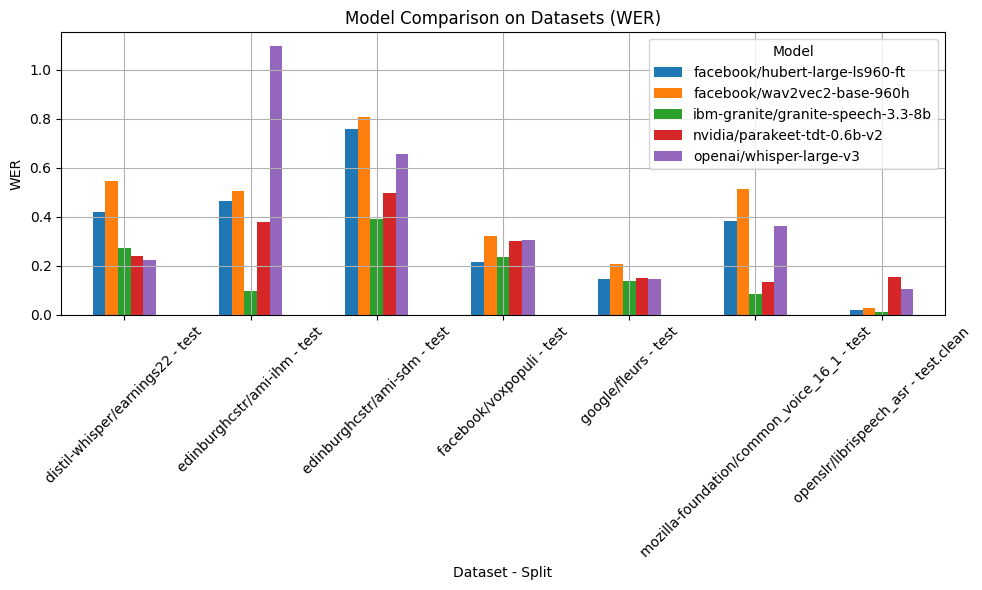

In [11]:
# Load the CSV data
df = pd.read_csv("/root/workspace/experiment/asr_comparison_results.csv")  # replace with your CSV filename

# Combine dataset and split into one column for clarity
df["dataset_split"] = df["dataset"] + " - " + df["split"]

# Choose the metric to visualize: "WER" or "CER"
metric = "WER"

# Pivot the data to get models as columns, dataset_split as index
pivot_df = df.pivot(index="dataset_split", columns="model", values=metric)

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title(f"Model Comparison on Datasets ({metric})")
plt.ylabel(metric)
plt.xlabel("Dataset - Split")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()